In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import napari
import os
from skimage import io
import morphotrack.image
import morphotrack.points
import morphotrack.align
import pickle
from matplotlib import pyplot as plt
from scipy import interpolate

import importlib
import morphotrack.nonlinear_align
import morphotrack.track
import morphotrack.distance
importlib.reload(morphotrack.image)

import seaborn as sns
import pandas as pd

sns.set(font_scale = 1.3)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Arial']})
sns.set_style("ticks")

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cross_decomposition import PLSRegression
from sklearn import model_selection
from scipy.stats import zscore, pearsonr

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
# read tracks
tracks_original = {
    'track_01':xr.open_dataset('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/track_ds.nc').load(),
    'track_02':xr.open_dataset('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/track_ds.nc').load(),
    'track_v1':xr.open_dataset('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/track_ds_fft.nc').load(),
    'track_v2':xr.open_dataset('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/track_ds_fft.nc').load(),
}

# read cell coordinates
cell_coords = {
    'track_01':{
        'nuclei':pd.read_csv('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'slc17a7':pd.read_csv('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/R01_R01/R01ch640_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'plp1':pd.read_csv('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/R02_R01/R02ch640_to_R01_segmentation_old/coord_centroids.csv',index_col=0)
    },
    'track_02':{
        'nuclei':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'slc17a7':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/R01_R01/R01ch640_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'plp1':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/R02_R01/R02ch640_to_R01_segmentation/coord_centroids.csv',index_col=0)
    },
    'track_v1':{
        'nuclei':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'slc17a7':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/R01_R01/R01ch640_to_R01_segmentation/coord_centroids.csv',index_col=0),
        # 'plp1':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/R02_R01/R02ch640_to_R01_segmentation/coord_centroids.csv',index_col=0)
    },
    'track_v2':{
        'nuclei':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'slc17a7':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/R01_R01/R01ch640_to_R01_segmentation/coord_centroids.csv',index_col=0),
        'plp1':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/R02_R01/R02ch640_to_R01_segmentation/coord_centroids.csv',index_col=0)
    },

}

# load images for visualization
image_set = {
    'track_01':{
        'nuclei':io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R02_ch488_10um.tif'),
        'vessel':io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R01_ch561_10um.tif'),
        'slc17a7':io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R01_ch640_10um.tif'),
        'plp1':io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R02_ch640_10um.tif')
    },
    'track_02':{
        'nuclei':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R02_ch488_10um.tif'),
        'vessel':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R01_ch561_10um.tif'),
        'slc17a7':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R01_ch640_10um.tif'),
        'plp1':io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R02_ch640_10um.tif')
    },
    'track_v1':{
        'nuclei':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/R02_ch488_10um.tif'),
        'vessel':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/R01_ch561_10um.tif'),
        'slc17a7':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/R01_ch640_10um.tif'),
        'plp1':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/R02_ch640_10um.tif')
    },
    'track_v2':{
        'nuclei':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/R02_ch488_10um.tif'),
        'vessel':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/R01_ch561_10um.tif'),
        'slc17a7':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/R01_ch640_10um.tif'),
        'plp1':io.imread('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/R02_ch640_10um.tif')
    },
}

# selection of the tracks
selection_set = {
    'track_01':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/filter_da.nc').load().all(axis=0),
    'track_02':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/filter_da.nc').load().all(axis=0),
    'track_v1':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220806_visual_01_R01/morphotrack/filter_da_fft.nc').load().all(axis=0),
    'track_v2':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/filter_da_fft.nc').load().all(axis=0),
}

In [3]:
# mask 
mask_set = {
    'track_01':io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/lcmask.tif'),
}

color_dict = {
    'track_01':'#5dfa41',
    'track_02':'#148700',
    'track_v1':'#e813e4',
    'track_v2':'#a72ef2',
}

In [4]:
# rename tracks and make new data arrays.

tracks = {}
track_counter = 0
for key in tracks_original:
    # selection based on the selection array
    if key in selection_set.keys():
        track_selection = selection_set[key].track[selection_set[key].data]
        track_d = tracks_original[key].copy().sel(track=track_selection.data)
    else:
        track_d = tracks_original[key].copy()
    # selectoin based on the mask
    if key in mask_set.keys():
        track_stack = track_d.Position.stack(pos=['time', 'track'])
        sel,_ = morphotrack.track.fetch_value_in_range(mask_set[key]!=0, track_stack.fillna(-1).data.T)
        rm_tracks = track_stack.track[sel].data
        track_d = track_d.sel(track=~track_d.track.isin(rm_tracks))
    
    # reset track numbers
    track_d = track_d.assign_coords({'track': np.arange(track_counter,track_counter+track_d.track.size)})
    tracks[key] = track_d
    track_counter += track_d.track.size

In [5]:
io_directory = '/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/cell_analysis'

In [6]:
# read cellular coordinate
scaling_factor = np.asarray([3,0.65,0.65])
for key in cell_coords:
    for i in cell_coords[key]:
        coords = cell_coords[key][i].loc[:,['centroid-0','centroid-1','centroid-2']] * scaling_factor / 10# convert unit to 10 um for consistency
        cell_coords[key][i] = coords.to_numpy()

## Get integral transformation displacement

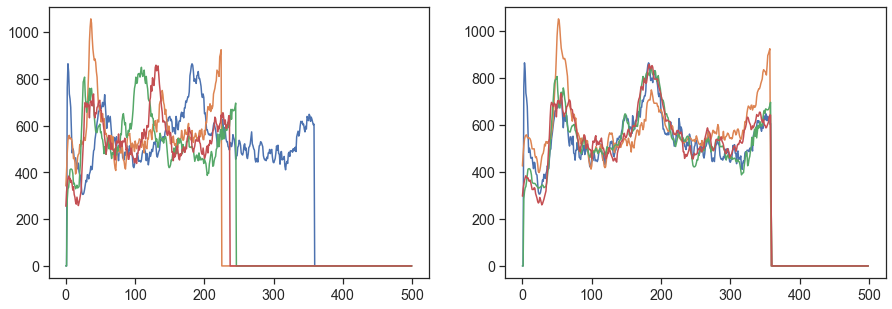

In [7]:
# standard alignment
std_01 = tracks_original['track_01'].Standard.isel(track=0).data
std_02 = tracks_original['track_02'].Standard.isel(track=0).data
std_v1 = tracks_original['track_v1'].Standard.isel(track=0).data
std_v2 = tracks_original['track_v2'].Standard.isel(track=0).data

std_01_02, arg01_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_01)
arg02_02 = np.arange(std_02.size)
std_v1_02, argv1_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_v1)
std_v2_02, argv2_02 = morphotrack.nonlinear_align.non_linear_align_1d(std_02,std_v2)

standard_shifts = {
    'track_01':arg01_02,
    'track_02':arg02_02,
    'track_v1':argv1_02,
    'track_v2':argv2_02,
}

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

axs[0].plot(std_02)
axs[0].plot(std_01)
axs[0].plot(std_v1)
axs[0].plot(std_v2)

axs[1].plot(std_02)
axs[1].plot(std_01_02)
axs[1].plot(std_v1_02)
axs[1].plot(std_v2_02)

## Convert to counts per kernel volume

In [8]:
def count_warp(track, counts, disp):
    warp_arg = morphotrack.align.composite_displacement(
        track.Total_arg.sel(displacement='t2s'),
        np.repeat(disp[:,np.newaxis], track.track.size, axis=1).T
    )

    transformed = track.Gray_counts.copy()
    transformed[:] = morphotrack.align.positional_mapping(counts, warp_arg)
    
    return transformed

In [9]:
tissue_sets = {}
half_thickness = 2.5 # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer
cell_set = ['nuclei','plp1']
# g = 'slc17a7'

for g in cell_set:
    arrs = []
    for tr in ['track_01','track_02','track_v2']:
        if g == 'nuclei':
            kc_xr = tracks[tr].Gray_counts.copy()
        else:
            kc = morphotrack.points.count_around_position_in_disk_kernel(tracks[tr].Position, cell_coords[tr][g], half_thickness, radius)
            kc = kc.fillna(0)
            # kc_warped = morphotrack.align.positional_mapping(kc*tracks[tr].Gray_loc, tracks[tr].Total_arg.sel(displacement='t2s'))

            # fix coordinate
            kc_xr = tracks[tr].Gray_counts.copy()
            kc_xr[:] = 0
            kc_xr = kc_xr + kc

        warped_kc = count_warp(tracks[tr], kc_xr, standard_shifts[tr])
        warped_kc = warped_kc.assign_coords({'track_set': ('track',np.full(warped_kc.track.size,tr))})
        arrs.append(warped_kc)
    # 
    tissue_sets[g] = xr.concat(arrs,dim='track')

In [10]:
### Here is how I index by non dimensional coordinate
### a.where(a.track_set=='coord', drop=True)
g = 'plp1'
ex_ratio = (tissue_sets[g] / tissue_sets['nuclei'])
ex_ratio = ex_ratio.where(ex_ratio.data!=np.inf,np.nan)
viewer = napari.Viewer()
viewer.add_image(ex_ratio.data, contrast_limits=[0,1], name='excitatory_ratio', colormap='gray', blending='additive')
viewer.add_image(tissue_sets['nuclei'].data, name='nuclei', colormap='gray', blending='additive')
viewer.add_image(tissue_sets[g].data, name=g, colormap='gray', blending='additive')

Validation errors in config file(s).
The following fields have been reset to the default value:

schema_version
  value is not a valid tuple (type=type_error.tuple)



<Image layer 'plp1' at 0x7f9538099fa0>

In [11]:
#where(a.track_set=='coord', drop=True)

[0.2182     0.11713738 0.10580765 0.06591427 0.04909585 0.03647634
 0.02569556 0.02119659 0.0166605  0.01510099]
0.6712851234891959


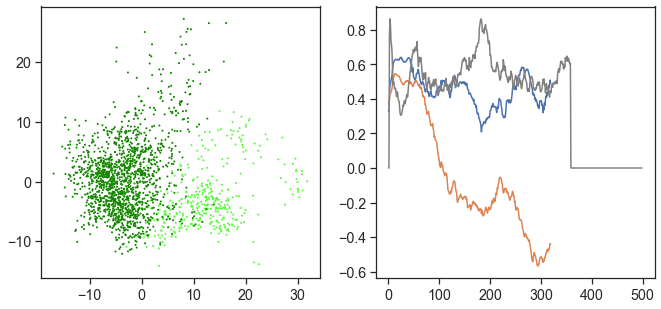

In [111]:
# trim the white matter to exclude the influence of the white matter.
trim_start = 0
trim_end = 320
combined_tracks_zscore = zscore(ex_ratio.fillna(0).data, axis=0)

pca = PCA().fit(combined_tracks_zscore[:,trim_start:trim_end])
pcs = pca.transform(combined_tracks_zscore[:,trim_start:trim_end])
pc1 = pcs[:,0]
pc2 = pcs[:,1]
pc3 = pcs[:,2]

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

colors = np.full(pc1.shape,'#b1eba7')
for tr in tracks:
    idx = tissue_sets['slc17a7'].track[tissue_sets['slc17a7'].track_set==tr].data
    colors[idx] = color_dict[tr]

fig, axs = plt.subplots(ncols=2, figsize=(11,5))

# axs[0].scatter(pc1,pc2,s=1,c=colors)
for tr in ['track_01','track_02']:
    idx = tissue_sets['slc17a7'].track[tissue_sets['slc17a7'].track_set==tr].data
    axs[0].scatter(pc1[idx],pc2[idx],s=1,c=colors[idx])

axs[1].plot(-loadings[:,0]) 
axs[1].plot(loadings[:,1]) 
axs[1].plot(std_02[trim_start:]/1000,c='gray')

component_num = 10
print(pca.explained_variance_ratio_[:component_num])
print(pca.explained_variance_ratio_[:component_num].sum())
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig5/PC1_flux.svg')

In [75]:
#

In [151]:
viewer = napari.Viewer()
viewer.add_image(kernel_counts['slc17a7'],colormap='magenta',blending='additive')
viewer.add_image(kernel_counts['plp1'],colormap='cyan',blending='additive')
viewer.add_image(tracks[tr].Total_warped.sel(displacement='t2s'),colormap='green',blending='additive')
viewer.add_image(kernel_counts['slc17a7'] / tracks[tr].Total_warped.sel(displacement='t2s'),contrast_limits=[0,1],colormap='turbo',blending='additive', visible=False)
viewer.add_image(kernel_counts['plp1'] / tracks[tr].Total_warped.sel(displacement='t2s'),contrast_limits=[0,1],colormap='turbo',blending='additive', visible=False)

<Image layer 'Image [4]' at 0x7fce14d4d4c0>

In [146]:
# visualization in original space
g = 'slc17a7'
img = morphotrack.image.visualize_in_original_space(tracks[tr].Position, kernel_counts[g] / tracks[tr].Total_warped.sel(displacement='t2s'), image_set[tr]['nuclei'].shape)

viewer = napari.Viewer()
viewer.add_image(img,colormap='turbo',blending='additive')
viewer.add_image(image_set[tr][g],colormap='gray',blending='additive')
viewer.add_points(
    cell_coords[tr][g],
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc'
)
# label = viewer.add_labels(np.zeros(img.shape).astype(int))

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'Points' at 0x7fce16a0f220>

(0.0, 493.8)

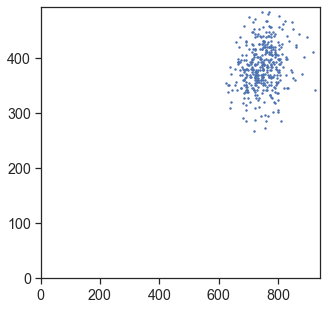

In [131]:
# get scatter plot of nucleic density and slc17a7
# those two should be very similar
reference_time = 140

n_dens = tracks[tr].Total_warped.sel(displacement='t2s',time=reference_time)
g_dens = kernel_counts[g].sel(time=reference_time)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.scatter(n_dens,g_dens,s=2)
ax.set_xlim(0);ax.set_ylim(0)

In [152]:
# io.imsave('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/lcmask.tif',label.data.astype(np.int8))

In [76]:
reference_time = 170 # time corresponding to layer IV is a good choice.
ref_time_in_standard = track_ds.Total_arg.sel(displacement='t2s').sel(time=reference_time)
layer_position = []
for ti, tr in zip(ref_time_in_standard.data,ref_time_in_standard.track.data):
    layer_position.append(track_ds.Position.sel(track=tr).interp(time=ti))
layer_position = xr.concat(layer_position,dim='track')

clf = pickle.load(open(os.path.join(io_directory,'model.pkl'), 'rb'))
norm_flow_on_coordinate = morphotrack.points.model_to_get_flow_func(clf.degree, clf)
local_flux = morphotrack.points.get_local_flux(layer_position.data, norm_flow_on_coordinate, radius)

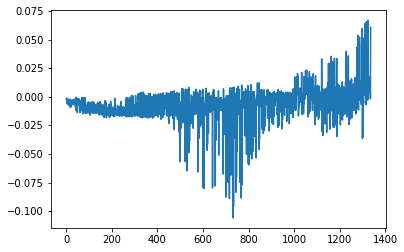

In [80]:
plt.plot(local_flux)